<h3>导入包</h3>

In [1]:
import os
import logging
from datetime import datetime
from typing import Optional, Union
from chinese_calendar import is_workday, is_holiday, is_in_lieu, get_holiday_detail
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, Timestamp, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.base import RegressorMixin
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, History
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(42)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.compat.v1.reset_default_graph()
clear_session()


warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

<h3>读入数据</h3>

<h4>读入A榜数据</h4>

In [2]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])

<h4>读入B榜数据</h4>

In [3]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_B/' + name + '_EC_B.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)
data_dict

{'二层插座':                    time     value
 0   2013-08-03 00:00:00  0.164062
 1   2013-08-03 00:15:00  0.121094
 2   2013-08-03 00:30:00  0.101562
 3   2013-08-03 00:45:00  0.087891
 4   2013-08-03 01:00:00  0.103516
 ..                  ...       ...
 667 2015-08-10 22:45:00  0.093750
 668 2015-08-10 23:00:00  0.089844
 669 2015-08-10 23:15:00  0.093750
 670 2015-08-10 23:30:00  0.097656
 671 2015-08-10 23:45:00  0.074219
 
 [64072 rows x 2 columns], '二层照明':                    time     value
 0   2013-08-03 00:00:00  0.500000
 1   2013-08-03 00:15:00  0.507812
 2   2013-08-03 00:30:00  0.476562
 3   2013-08-03 00:45:00  0.117188
 4   2013-08-03 01:00:00  0.000000
 ..                  ...       ...
 667 2015-08-10 22:45:00  0.062500
 668 2015-08-10 23:00:00  0.078125
 669 2015-08-10 23:15:00  0.062500
 670 2015-08-10 23:30:00  0.109375
 671 2015-08-10 23:45:00  0.273438
 
 [64320 rows x 2 columns], '一层插座':                    time     value
 0   2013-08-03 00:00:00  0.113281
 1   2013-

<h3>读入天气数据</h3>

In [4]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh = wh.set_index("time", drop=True)
wh

,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,
2013-08-03 00:00:00,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,25,75,0.4,1007,东北风,35,7,2


<h3>合并数据</h3>

<h4>对齐数据</h4>

In [5]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

,time,value_socket_2,value_light_2,value_socket_1,value_light_1,value_air
0,2013-08-03 00:00:00,0.164062,0.500000,0.113281,0.542969,4.234375
1,2013-08-03 00:15:00,0.121094,0.507812,0.273438,0.542969,5.093750
2,2013-08-03 00:30:00,0.101562,0.476562,0.277344,0.515625,3.234375
3,2013-08-03 00:45:00,0.087891,0.117188,0.218750,0.437500,3.187500
4,2013-08-03 01:00:00,0.103516,0.000000,0.082031,0.406250,3.171875
...,...,...,...,...,...,...
63832,2015-08-10 22:45:00,0.093750,0.062500,0.125000,0.234375,1.750000
63833,2015-08-10 23:00:00,0.089844,0.078125,0.117188,0.218750,1.781250
63834,2015-08-10 23:15:00,0.093750,0.062500,0.132812,0.218750,1.718750
63835,2015-08-10 23:30:00,0.097656,0.109375,0.179688,0.203125,2.937500


<h4>将一二层数据相加</h4>

<AxesSubplot:>

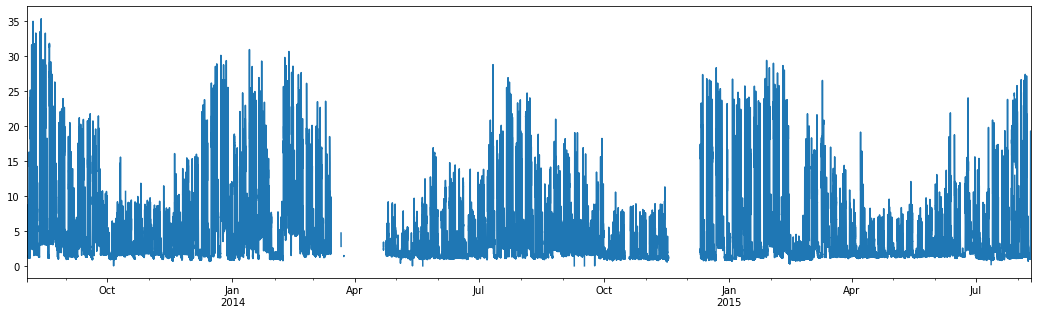

In [6]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data["value_total"] = data.sum(axis=1)
data = data.set_index("time", drop=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq="15T"))
data["value_total"].plot(figsize=(18,5))

<h3>处理缺失值</h3>

<h4>查看大段的nan</h4>

In [7]:
data.loc['2014-03-14 13:00:00' : '2014-04-23 20:15:00']

,value_air,value_socket,value_light,value_total
2014-03-14 13:00:00,2.43750,1.539062,1.710938,5.687500
2014-03-14 13:15:00,2.37500,1.769531,1.777344,5.921875
2014-03-14 13:30:00,2.37500,1.347656,1.882812,5.605469
2014-03-14 13:45:00,NaN,NaN,NaN,NaN
2014-03-14 14:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-04-23 19:15:00,NaN,NaN,NaN,NaN
2014-04-23 19:30:00,NaN,NaN,NaN,NaN
2014-04-23 19:45:00,NaN,NaN,NaN,NaN
2014-04-23 20:00:00,NaN,NaN,NaN,NaN


In [8]:
data.loc['2014-11-17 08:00:00' : '2014-12-10 17:15:00']

,value_air,value_socket,value_light,value_total
2014-11-17 08:00:00,0.59375,0.390625,0.320312,1.304688
2014-11-17 08:15:00,0.59375,0.207031,0.281250,1.082031
2014-11-17 08:30:00,NaN,NaN,NaN,NaN
2014-11-17 08:45:00,NaN,NaN,NaN,NaN
2014-11-17 09:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-12-10 16:15:00,NaN,NaN,NaN,NaN
2014-12-10 16:30:00,NaN,NaN,NaN,NaN
2014-12-10 16:45:00,11.62500,1.718750,2.039062,15.382812
2014-12-10 17:00:00,12.15625,1.757812,2.039062,15.953125


<h4>查看所有缺失值的index，并将该小时的Timestamp记录下来</h4>

In [9]:
nan_index = data[data["value_total"].isnull()].index
nan_index_hours = []
for idx in nan_index:
    nan_index_hour = Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=idx.hour)
    nan_index_hours.append(nan_index_hour)
nan_index_hours.extend(pd.date_range("2014-03-14 13:00:00", "2014-04-23 20:00:00", freq="1H").tolist())
nan_index_hours.extend(pd.date_range("2014-11-17 08:00:00", "2014-12-10 16:00:00", freq="1H").tolist())
nan_index_hours = np.unique(nan_index_hours)
DatetimeIndex(nan_index_hours)

DatetimeIndex(['2013-08-04 12:00:00', '2013-08-07 07:00:00',
               '2013-10-14 10:00:00', '2013-10-14 11:00:00',
               '2013-10-14 12:00:00', '2013-10-14 13:00:00',
               '2013-10-14 14:00:00', '2013-10-14 15:00:00',
               '2013-10-14 16:00:00', '2013-10-14 17:00:00',
               ...
               '2015-07-30 08:00:00', '2015-07-30 09:00:00',
               '2015-07-30 11:00:00', '2015-07-30 12:00:00',
               '2015-07-30 14:00:00', '2015-07-30 15:00:00',
               '2015-07-30 17:00:00', '2015-07-30 18:00:00',
               '2015-07-30 20:00:00', '2015-07-30 21:00:00'],
              dtype='datetime64[ns]', length=1860, freq=None)

<h4>对少数缺失值进行插值补全</h4>

In [10]:
data["value_air"] = data["value_air"].interpolate(method="time")
data["value_light"] = data["value_light"].interpolate(method="time")
data["value_socket"] = data["value_socket"].interpolate(method="time")
data["value_total"] = data["value_total"].interpolate(method="time")

<h3>按照每小时相加</h3>

In [11]:
data = data.resample("1H").sum()
data.loc["2014-03-14 13:00:00" : "2014-04-23 20:00:00", :] = np.nan
data.loc["2014-11-17 08:00:00" : "2014-12-10 16:00:00", :] = np.nan
data = data.dropna()
data

,value_air,value_socket,value_light,value_total
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484
...,...,...,...,...
2015-08-10 19:00:00,8.500000,1.277344,3.750000,13.527344
2015-08-10 20:00:00,3.531250,1.292969,2.382812,7.207031
2015-08-10 21:00:00,3.312500,1.203125,1.117188,5.632812
2015-08-10 22:00:00,5.000000,1.035156,1.234375,7.269531


<h3>合并天气数据</h3>

In [12]:
data = pd.merge(data, wh, how="right", left_index=True, right_index=True)
data

,value_air,value_socket,value_light,value_total,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,东北风,35,7,2


<h3>TODO 特征工程</h3>

<h4>修改列名</h4>

In [13]:
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})

<h4>自定义特征工程</h4>

In [14]:
data['workday'] = list(map(lambda x: int(is_workday(x)), data.index.to_list()))
data['hour'] = list(map(lambda x: x.hour, data.index.to_list()))
data['week'] = list(map(lambda x: x.weekday(), data.index.to_list()))
data['day'] = list(map(lambda x: x.day, data.index.to_list()))
data['month'] = list(map(lambda x: x.month, data.index.to_list()))
data['year'] = list(map(lambda x: x.year, data.index.to_list()))
data["temp"] = data["temp"].rolling("12H").mean()
# data = pd.concat([data.loc[: "2015-08-03 23:00:00"].dropna(), data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]], axis=0)
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_direction,wind_angle,wind_speed,cloud,workday,hour,week,day,month,year
time,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28.000000,88,1.0,1006,东南风,159,9,71,0,0,5,3,8,2013
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28.000000,88,0.9,1006,东南风,155,8,75,0,1,5,3,8,2013
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28.000000,89,0.7,1006,东南风,150,8,54,0,2,5,3,8,2013
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27.750000,90,0.5,1006,东南风,151,8,25,0,3,5,3,8,2013
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27.600000,90,0.2,1006,东南风,151,8,35,0,4,5,3,8,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,东北风,43,11,1,1,19,0,24,8,2015
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,东北风,45,9,0,1,20,0,24,8,2015
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,东北风,35,7,2,1,21,0,24,8,2015


<h3>对类别特征onehot</h3>

<h4>对风向进行onehot</h4>

In [15]:
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,month,year,东北风,东南风,东风,北风,南风,西北风,西南风,西风
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28.000000,88,1.0,1006,159,9,...,8,2013,0,1,0,0,0,0,0,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28.000000,88,0.9,1006,155,8,...,8,2013,0,1,0,0,0,0,0,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28.000000,89,0.7,1006,150,8,...,8,2013,0,1,0,0,0,0,0,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27.750000,90,0.5,1006,151,8,...,8,2013,0,1,0,0,0,0,0,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27.600000,90,0.2,1006,151,8,...,8,2013,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,43,11,...,8,2015,1,0,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,45,9,...,8,2015,1,0,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,35,7,...,8,2015,1,0,0,0,0,0,0,0


<h4>对星期几进行onehot</h4>

In [16]:
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["week"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,西北风,西南风,西风,星期1,星期2,星期3,星期4,星期5,星期6,星期7
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28.000000,88,1.0,1006,159,9,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28.000000,88,0.9,1006,155,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28.000000,89,0.7,1006,150,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27.750000,90,0.5,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27.600000,90,0.2,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,43,11,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,45,9,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,35,7,...,0,0,0,1,0,0,0,0,0,0


<h3>构建模型</h3>

In [17]:
def r2_metric(y_pred, y_true):
    result1 = r2_score(y_true[0:24], y_pred[0:24])
    result2 = r2_score(y_true[24:48], y_pred[24:48])
    result3 = r2_score(y_true[48:72], y_pred[48:72])
    result4 = r2_score(y_true[72:96], y_pred[72:96])
    result5 = r2_score(y_true[96:120], y_pred[96:120])
    result6 = r2_score(y_true[120:144], y_pred[120:144])
    result7 = r2_score(y_true[144:168], y_pred[144:168])
    return "r2 score", 0.25 * result1 + 0.15 * (result2 + result3 + result4) + 0.1 * (result5 + result6 + result7), True

In [18]:
def cross_validation(estimator: RegressorMixin, n_splits: int, x_train_val: DataFrame, y_train_val: Series, x_test: DataFrame) -> np.ndarray:
    """
    交叉验证\n
    """
    models = []
    scores = []
    oof_preds = np.zeros((x_train_val.shape[0],))
    test_preds = np.zeros((x_test.shape[0],))
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train_val, y_train_val)):
        x_train, x_val, y_train, y_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index], y_train_val[train_index], y_train_val[val_index]

        estimator = estimator.fit(x_train, y_train, eval_set=(x_val, y_val), eval_metric=r2_metric, early_stopping_rounds=20)
        models.append(estimator)

        oof_preds[val_index] = estimator.predict(x_val, num_iteration=estimator.best_iteration_)
        test_preds += estimator.predict(x_test, num_iteration=estimator.best_iteration_) / kfold.n_splits
        score = r2_score(y_val, estimator.predict(x_val, num_iteration=estimator.best_iteration_))
        
        logging.info(f'############ fold: {fold}, r2: {score} ###########')
        scores.append(score)
    logging.info(f'############ cross validation r2 score: {np.mean(scores)} ###########')
    return test_preds

In [19]:
def shift_column(ser: Series, num: int) -> DataFrame:
    """
    取历史值\n
    """
    result = DataFrame()
    for i in range(1, num + 1):
        result["%s-%d" % (ser.name, i)] = ser.shift(i)
    return result

In [20]:
def clip_maxmin(ser: Series, _clip_min_: bool, _clip_max_: bool) -> Series:
    """
    把最小值最大值变为次小值次大值\n
    """
    result = ser.copy()
    if _clip_min_:
        idx = result.argmin()
        result[result == result.min()] = np.nan
        result.iloc[idx] = result.min()
    if _clip_max_:
        idx = result.argmax()
        result[result == result.max()] == np.nan
        result.iloc[idx] = result.max()
    return result

In [21]:
def clip_value(ser: Union[Series, np.ndarray], _min_val_: Optional[float] = None, _max_val_: Optional[float] = None) -> Series:
    """
    把小于最小值的替换成最小值\n
    """
    result = ser.copy()
    if _min_val_:
        result[result < _min_val_] = _min_val_
    if _max_val_:
        result[result > _max_val_] = _max_val_
    return result

In [22]:
@tf.function
def split_xy(x):
    return x[:, :, 1:], x[:, :, 0]

<h4>针对socket构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

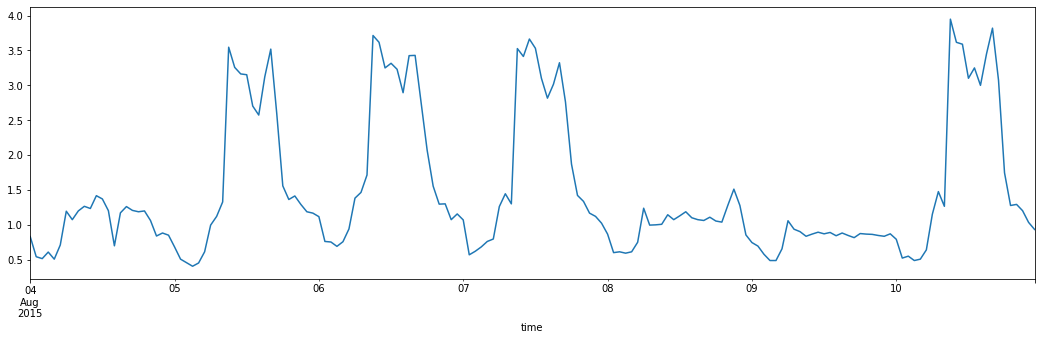

In [23]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_socket"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [24]:
data_socket = data.drop(columns=["value_light", "value_air", "value_total"])
x_train_socket = data_socket.drop(columns=["value_socket"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_socket = data_socket["value_socket"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_socket = data_socket.drop(columns=["value_socket"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_socket.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [25]:
model_socket1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred1 = model_socket1.predict(x_test_socket)

<h5>取最后7*24个点作为模型2预测值</h5>

In [26]:
socket_pred2 = data_socket.loc[: "2015-08-10 23:00:00", "value_socket"].values[-7*24:]

<h5>构建catboost</h5>

In [27]:
model_socket3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred3 = model_socket3.predict(x_test_socket)

Learning rate set to 0.063357
0:	learn: 1.9149907	total: 55.4ms	remaining: 55.3s
1:	learn: 1.8257241	total: 57.8ms	remaining: 28.9s
2:	learn: 1.7438299	total: 60.3ms	remaining: 20s
3:	learn: 1.6675883	total: 62.6ms	remaining: 15.6s
4:	learn: 1.5972630	total: 64.8ms	remaining: 12.9s
5:	learn: 1.5321158	total: 66.8ms	remaining: 11.1s
6:	learn: 1.4728040	total: 68.9ms	remaining: 9.78s
7:	learn: 1.4180795	total: 70.9ms	remaining: 8.79s
8:	learn: 1.3680955	total: 72.9ms	remaining: 8.02s
9:	learn: 1.3223375	total: 74.8ms	remaining: 7.41s
10:	learn: 1.2806688	total: 76.8ms	remaining: 6.9s
11:	learn: 1.2424696	total: 78.7ms	remaining: 6.48s
12:	learn: 1.2084809	total: 80.6ms	remaining: 6.12s
13:	learn: 1.1763844	total: 82.6ms	remaining: 5.82s
14:	learn: 1.1474642	total: 84.5ms	remaining: 5.55s
15:	learn: 1.1215777	total: 86.6ms	remaining: 5.32s
16:	learn: 1.0976350	total: 88.5ms	remaining: 5.12s
17:	learn: 1.0762909	total: 90.4ms	remaining: 4.93s
18:	learn: 1.0564018	total: 92.2ms	remaining: 4

246:	learn: 0.5787389	total: 530ms	remaining: 1.62s
247:	learn: 0.5782970	total: 532ms	remaining: 1.61s
248:	learn: 0.5774454	total: 535ms	remaining: 1.61s
249:	learn: 0.5770902	total: 537ms	remaining: 1.61s
250:	learn: 0.5767263	total: 538ms	remaining: 1.61s
251:	learn: 0.5761966	total: 540ms	remaining: 1.6s
252:	learn: 0.5758435	total: 542ms	remaining: 1.6s
253:	learn: 0.5752494	total: 544ms	remaining: 1.6s
254:	learn: 0.5749066	total: 546ms	remaining: 1.59s
255:	learn: 0.5743524	total: 548ms	remaining: 1.59s
256:	learn: 0.5738146	total: 550ms	remaining: 1.59s
257:	learn: 0.5733778	total: 552ms	remaining: 1.59s
258:	learn: 0.5728873	total: 556ms	remaining: 1.59s
259:	learn: 0.5725415	total: 558ms	remaining: 1.59s
260:	learn: 0.5719664	total: 560ms	remaining: 1.59s
261:	learn: 0.5715078	total: 562ms	remaining: 1.58s
262:	learn: 0.5710343	total: 564ms	remaining: 1.58s
263:	learn: 0.5705686	total: 567ms	remaining: 1.58s
264:	learn: 0.5702299	total: 569ms	remaining: 1.58s
265:	learn: 0.5

429:	learn: 0.5135739	total: 890ms	remaining: 1.18s
430:	learn: 0.5132494	total: 892ms	remaining: 1.18s
431:	learn: 0.5129573	total: 894ms	remaining: 1.18s
432:	learn: 0.5126744	total: 896ms	remaining: 1.17s
433:	learn: 0.5125140	total: 898ms	remaining: 1.17s
434:	learn: 0.5122708	total: 900ms	remaining: 1.17s
435:	learn: 0.5120528	total: 902ms	remaining: 1.17s
436:	learn: 0.5116991	total: 904ms	remaining: 1.16s
437:	learn: 0.5112571	total: 906ms	remaining: 1.16s
438:	learn: 0.5110648	total: 908ms	remaining: 1.16s
439:	learn: 0.5107933	total: 909ms	remaining: 1.16s
440:	learn: 0.5106038	total: 911ms	remaining: 1.16s
441:	learn: 0.5104572	total: 913ms	remaining: 1.15s
442:	learn: 0.5100983	total: 915ms	remaining: 1.15s
443:	learn: 0.5099148	total: 917ms	remaining: 1.15s
444:	learn: 0.5097010	total: 919ms	remaining: 1.15s
445:	learn: 0.5095972	total: 921ms	remaining: 1.14s
446:	learn: 0.5093278	total: 923ms	remaining: 1.14s
447:	learn: 0.5090788	total: 925ms	remaining: 1.14s
448:	learn: 

613:	learn: 0.4741400	total: 1.25s	remaining: 786ms
614:	learn: 0.4739947	total: 1.25s	remaining: 784ms
615:	learn: 0.4738306	total: 1.25s	remaining: 782ms
616:	learn: 0.4735309	total: 1.26s	remaining: 780ms
617:	learn: 0.4733835	total: 1.26s	remaining: 778ms
618:	learn: 0.4731619	total: 1.26s	remaining: 776ms
619:	learn: 0.4730038	total: 1.26s	remaining: 773ms
620:	learn: 0.4726246	total: 1.26s	remaining: 771ms
621:	learn: 0.4724973	total: 1.26s	remaining: 769ms
622:	learn: 0.4723009	total: 1.27s	remaining: 767ms
623:	learn: 0.4722234	total: 1.27s	remaining: 765ms
624:	learn: 0.4721111	total: 1.27s	remaining: 763ms
625:	learn: 0.4719541	total: 1.27s	remaining: 761ms
626:	learn: 0.4719103	total: 1.27s	remaining: 759ms
627:	learn: 0.4717648	total: 1.28s	remaining: 757ms
628:	learn: 0.4715907	total: 1.28s	remaining: 755ms
629:	learn: 0.4714171	total: 1.28s	remaining: 752ms
630:	learn: 0.4713353	total: 1.28s	remaining: 750ms
631:	learn: 0.4711934	total: 1.28s	remaining: 748ms
632:	learn: 

800:	learn: 0.4457781	total: 1.61s	remaining: 400ms
801:	learn: 0.4457194	total: 1.61s	remaining: 398ms
802:	learn: 0.4455571	total: 1.61s	remaining: 396ms
803:	learn: 0.4454479	total: 1.62s	remaining: 394ms
804:	learn: 0.4452614	total: 1.62s	remaining: 392ms
805:	learn: 0.4451163	total: 1.62s	remaining: 390ms
806:	learn: 0.4449790	total: 1.62s	remaining: 388ms
807:	learn: 0.4447516	total: 1.62s	remaining: 386ms
808:	learn: 0.4446724	total: 1.63s	remaining: 384ms
809:	learn: 0.4445880	total: 1.63s	remaining: 382ms
810:	learn: 0.4444353	total: 1.63s	remaining: 380ms
811:	learn: 0.4443148	total: 1.63s	remaining: 378ms
812:	learn: 0.4442602	total: 1.63s	remaining: 376ms
813:	learn: 0.4441182	total: 1.64s	remaining: 374ms
814:	learn: 0.4439617	total: 1.64s	remaining: 372ms
815:	learn: 0.4438536	total: 1.64s	remaining: 370ms
816:	learn: 0.4437455	total: 1.64s	remaining: 368ms
817:	learn: 0.4436816	total: 1.64s	remaining: 366ms
818:	learn: 0.4434651	total: 1.65s	remaining: 364ms
819:	learn: 

989:	learn: 0.4225321	total: 1.97s	remaining: 19.9ms
990:	learn: 0.4224429	total: 1.97s	remaining: 17.9ms
991:	learn: 0.4224167	total: 1.98s	remaining: 15.9ms
992:	learn: 0.4223271	total: 1.98s	remaining: 13.9ms
993:	learn: 0.4222758	total: 1.98s	remaining: 11.9ms
994:	learn: 0.4221813	total: 1.98s	remaining: 9.96ms
995:	learn: 0.4219490	total: 1.98s	remaining: 7.96ms
996:	learn: 0.4218683	total: 1.99s	remaining: 5.97ms
997:	learn: 0.4218000	total: 1.99s	remaining: 3.98ms
998:	learn: 0.4217387	total: 1.99s	remaining: 1.99ms
999:	learn: 0.4216975	total: 1.99s	remaining: 0us


<h5>构建xgboost</h5>

In [28]:
model_socket4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_socket, y_train_socket)
socket_pred4 = model_socket4.predict(x_test_socket)

<h5>构建深度模型</h5>

In [29]:
ds_socket1 = timeseries_dataset_from_array(
    data=data_socket.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket2 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket3 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket = ds_socket1.concatenate(ds_socket2).concatenate(ds_socket3).map(split_xy)
ds_socket

<MapDataset shapes: ((None, None, 27), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
124/124 [==============================] - 8s 41ms/step - loss: 6.7426 - mae: 1.8230
Epoch 2/100
124/124 [==============================] - 5s 38ms/step - loss: 1.6246 - mae: 0.8177
Epoch 3/100
124/124 [==============================] - 5s 39ms/step - loss: 1.2689 - mae: 0.7248
Epoch 4/100
124/124 [==============================] - 5s 38ms/step - loss: 1.1537 - mae: 0.6892
Epoch 5/100
124/124 [==============================] - 5s 38ms/step - loss: 1.0411 - mae: 0.6518
Epoch 6/100
124/124 [==============================] - 5s 38ms/step - loss: 0.9341 - mae: 0.6161
Epoch 7/100
124/124 [==============================] - 5s 38ms/step - loss: 0.8680 - mae: 0.5919
Epoch 8/100
124/124 [==============================] - 5s 38ms/step - loss: 0.8039 - mae: 0.5692
Epoch 9/100
124/124 [==============================] - 5s 38ms/step - loss: 0.7406 - mae: 0.5461
Epoch 10/100
124/124 [==============================] - 5s 38ms/step - loss: 0.6915 - mae: 0.5269
Epoch 11/100
124/124 [=======

124/124 [==============================] - 5s 39ms/step - loss: 0.0728 - mae: 0.1690
Epoch 85/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0656 - mae: 0.1572
Epoch 86/100
124/124 [==============================] - 5s 39ms/step - loss: 0.0622 - mae: 0.1550
Epoch 87/100
124/124 [==============================] - 5s 40ms/step - loss: 0.0627 - mae: 0.1554
Epoch 88/100
124/124 [==============================] - 5s 40ms/step - loss: 0.0595 - mae: 0.1503
Epoch 89/100
124/124 [==============================] - 5s 41ms/step - loss: 0.0623 - mae: 0.1546
Epoch 90/100
124/124 [==============================] - 5s 40ms/step - loss: 0.0594 - mae: 0.1511
Epoch 91/100
124/124 [==============================] - 5s 40ms/step - loss: 0.0586 - mae: 0.1489
Epoch 92/100
124/124 [==============================] - 5s 40ms/step - loss: 0.0602 - mae: 0.1516
Epoch 93/100
124/124 [==============================] - 5s 40ms/step - loss: 0.0571 - mae: 0.1466
Epoch 94/100
124/124 [===========

2023-04-11 18:32:04,808 [INFO] saving LSTM model to ../models/LSTM_socket.h5


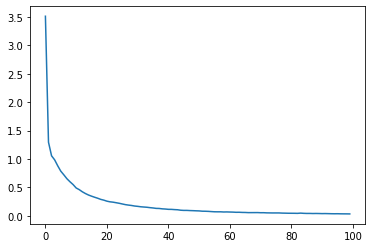

In [30]:
model_socket5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_socket.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_socket5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_socket5.load_weights("../models/LSTM_socket.h5")
    logging.info("loading LSTM model from ../models/LSTM_socket.h5")
except OSError as e:
    history: History = model_socket5.fit(
        ds_socket,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_socket5.save_weights("../models/LSTM_socket.h5")
    logging.info("saving LSTM model to ../models/LSTM_socket.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [31]:
socket_pred5 = model_socket5.predict(np.expand_dims(x_test_socket.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

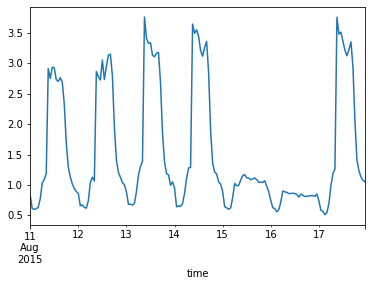

In [32]:
socket_pred = (socket_pred1 + socket_pred2 + socket_pred3 + socket_pred4 + socket_pred5) / 5
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"] = socket_pred
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot()

<h4>针对light构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

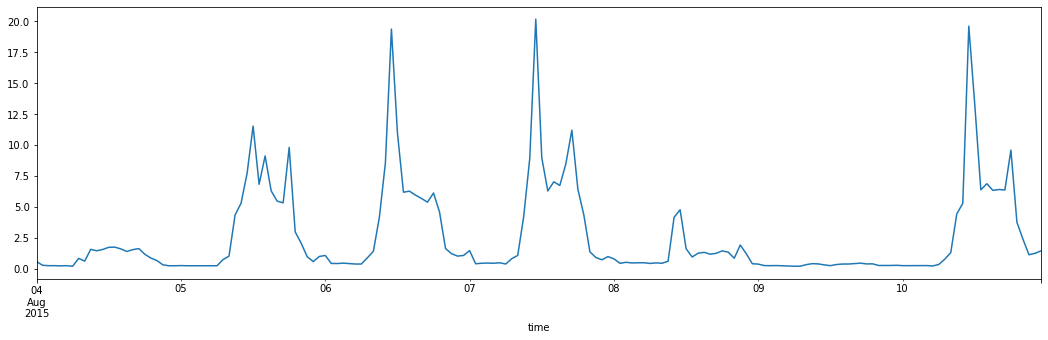

In [33]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_light"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [34]:
data_light = data.drop(columns=["value_socket", "value_air", "value_total", 'temp', 'humidity', 'atmos', 'wind_angle', 'wind_speed'])
x_train_light = data_light.drop(columns=["value_light"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_light = data_light["value_light"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_light = data_light.drop(columns=["value_light"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_light.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [35]:
model_light1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred1 = model_light1.predict(x_test_light)

<h5>取最后7*24个点作为模型2预测值</h5>

In [36]:
light_pred2 = data_light.loc[: "2015-08-10 23:00:00", "value_light"].values[-7*24:]

<h5>构建catboost</h5>

In [37]:
model_light3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred3 = model_light3.predict(x_test_light)

Learning rate set to 0.063357
0:	learn: 3.5451917	total: 2.81ms	remaining: 2.8s
1:	learn: 3.3801371	total: 5.4ms	remaining: 2.69s
2:	learn: 3.2283088	total: 8.06ms	remaining: 2.68s
3:	learn: 3.0888932	total: 10.7ms	remaining: 2.66s
4:	learn: 2.9611128	total: 13.3ms	remaining: 2.65s
5:	learn: 2.8443397	total: 15.9ms	remaining: 2.64s
6:	learn: 2.7375281	total: 18.5ms	remaining: 2.63s
7:	learn: 2.6374371	total: 21.1ms	remaining: 2.61s
8:	learn: 2.5463384	total: 23.7ms	remaining: 2.6s
9:	learn: 2.4634085	total: 26.1ms	remaining: 2.58s
10:	learn: 2.3871359	total: 28.5ms	remaining: 2.56s
11:	learn: 2.3138281	total: 30.9ms	remaining: 2.54s
12:	learn: 2.2508583	total: 33.3ms	remaining: 2.53s
13:	learn: 2.1881613	total: 35.7ms	remaining: 2.51s
14:	learn: 2.1357166	total: 38.1ms	remaining: 2.5s
15:	learn: 2.0874829	total: 40.8ms	remaining: 2.51s
16:	learn: 2.0396044	total: 43.3ms	remaining: 2.5s
17:	learn: 2.0016100	total: 45.7ms	remaining: 2.49s
18:	learn: 1.9628655	total: 48.2ms	remaining: 2.4

160:	learn: 1.3536452	total: 352ms	remaining: 1.83s
161:	learn: 1.3529896	total: 354ms	remaining: 1.83s
162:	learn: 1.3516852	total: 356ms	remaining: 1.83s
163:	learn: 1.3512538	total: 358ms	remaining: 1.83s
164:	learn: 1.3501994	total: 360ms	remaining: 1.82s
165:	learn: 1.3490741	total: 362ms	remaining: 1.82s
166:	learn: 1.3481669	total: 364ms	remaining: 1.82s
167:	learn: 1.3471965	total: 366ms	remaining: 1.81s
168:	learn: 1.3459146	total: 368ms	remaining: 1.81s
169:	learn: 1.3449241	total: 371ms	remaining: 1.81s
170:	learn: 1.3437675	total: 373ms	remaining: 1.81s
171:	learn: 1.3431336	total: 375ms	remaining: 1.8s
172:	learn: 1.3418640	total: 377ms	remaining: 1.8s
173:	learn: 1.3408807	total: 379ms	remaining: 1.8s
174:	learn: 1.3396768	total: 381ms	remaining: 1.8s
175:	learn: 1.3389982	total: 383ms	remaining: 1.79s
176:	learn: 1.3380680	total: 385ms	remaining: 1.79s
177:	learn: 1.3368604	total: 387ms	remaining: 1.79s
178:	learn: 1.3360500	total: 390ms	remaining: 1.79s
179:	learn: 1.33

332:	learn: 1.2281312	total: 711ms	remaining: 1.42s
333:	learn: 1.2276682	total: 713ms	remaining: 1.42s
334:	learn: 1.2271701	total: 715ms	remaining: 1.42s
335:	learn: 1.2266261	total: 717ms	remaining: 1.42s
336:	learn: 1.2262768	total: 719ms	remaining: 1.41s
337:	learn: 1.2256988	total: 721ms	remaining: 1.41s
338:	learn: 1.2249133	total: 724ms	remaining: 1.41s
339:	learn: 1.2242009	total: 726ms	remaining: 1.41s
340:	learn: 1.2236381	total: 728ms	remaining: 1.41s
341:	learn: 1.2232502	total: 730ms	remaining: 1.4s
342:	learn: 1.2229418	total: 732ms	remaining: 1.4s
343:	learn: 1.2224621	total: 734ms	remaining: 1.4s
344:	learn: 1.2221661	total: 736ms	remaining: 1.4s
345:	learn: 1.2216284	total: 738ms	remaining: 1.4s
346:	learn: 1.2209720	total: 740ms	remaining: 1.39s
347:	learn: 1.2201691	total: 742ms	remaining: 1.39s
348:	learn: 1.2197405	total: 744ms	remaining: 1.39s
349:	learn: 1.2193531	total: 746ms	remaining: 1.39s
350:	learn: 1.2189878	total: 748ms	remaining: 1.38s
351:	learn: 1.218

504:	learn: 1.1535156	total: 1.07s	remaining: 1.05s
505:	learn: 1.1532289	total: 1.07s	remaining: 1.05s
506:	learn: 1.1530299	total: 1.07s	remaining: 1.04s
507:	learn: 1.1529274	total: 1.08s	remaining: 1.04s
508:	learn: 1.1526410	total: 1.08s	remaining: 1.04s
509:	learn: 1.1522190	total: 1.08s	remaining: 1.04s
510:	learn: 1.1519812	total: 1.08s	remaining: 1.04s
511:	learn: 1.1517488	total: 1.08s	remaining: 1.03s
512:	learn: 1.1515743	total: 1.09s	remaining: 1.03s
513:	learn: 1.1506998	total: 1.09s	remaining: 1.03s
514:	learn: 1.1502994	total: 1.09s	remaining: 1.03s
515:	learn: 1.1499373	total: 1.09s	remaining: 1.02s
516:	learn: 1.1493638	total: 1.09s	remaining: 1.02s
517:	learn: 1.1492414	total: 1.1s	remaining: 1.02s
518:	learn: 1.1490154	total: 1.1s	remaining: 1.02s
519:	learn: 1.1485114	total: 1.1s	remaining: 1.02s
520:	learn: 1.1477060	total: 1.1s	remaining: 1.01s
521:	learn: 1.1474610	total: 1.1s	remaining: 1.01s
522:	learn: 1.1469866	total: 1.11s	remaining: 1.01s
523:	learn: 1.146

671:	learn: 1.0940360	total: 1.43s	remaining: 697ms
672:	learn: 1.0938613	total: 1.43s	remaining: 694ms
673:	learn: 1.0937570	total: 1.43s	remaining: 692ms
674:	learn: 1.0935009	total: 1.43s	remaining: 690ms
675:	learn: 1.0930003	total: 1.44s	remaining: 688ms
676:	learn: 1.0926667	total: 1.44s	remaining: 686ms
677:	learn: 1.0922967	total: 1.44s	remaining: 684ms
678:	learn: 1.0917445	total: 1.44s	remaining: 682ms
679:	learn: 1.0914458	total: 1.44s	remaining: 680ms
680:	learn: 1.0911005	total: 1.45s	remaining: 677ms
681:	learn: 1.0906409	total: 1.45s	remaining: 675ms
682:	learn: 1.0902431	total: 1.45s	remaining: 673ms
683:	learn: 1.0899249	total: 1.45s	remaining: 671ms
684:	learn: 1.0897261	total: 1.45s	remaining: 669ms
685:	learn: 1.0892353	total: 1.46s	remaining: 667ms
686:	learn: 1.0889671	total: 1.46s	remaining: 665ms
687:	learn: 1.0887331	total: 1.46s	remaining: 663ms
688:	learn: 1.0882117	total: 1.46s	remaining: 660ms
689:	learn: 1.0879578	total: 1.47s	remaining: 658ms
690:	learn: 

842:	learn: 1.0416930	total: 1.79s	remaining: 333ms
843:	learn: 1.0415551	total: 1.79s	remaining: 331ms
844:	learn: 1.0413720	total: 1.79s	remaining: 329ms
845:	learn: 1.0410170	total: 1.79s	remaining: 327ms
846:	learn: 1.0408897	total: 1.8s	remaining: 325ms
847:	learn: 1.0405826	total: 1.8s	remaining: 322ms
848:	learn: 1.0403600	total: 1.8s	remaining: 320ms
849:	learn: 1.0400712	total: 1.8s	remaining: 318ms
850:	learn: 1.0395261	total: 1.8s	remaining: 316ms
851:	learn: 1.0392832	total: 1.81s	remaining: 314ms
852:	learn: 1.0391356	total: 1.81s	remaining: 312ms
853:	learn: 1.0389001	total: 1.81s	remaining: 310ms
854:	learn: 1.0384188	total: 1.81s	remaining: 308ms
855:	learn: 1.0382091	total: 1.81s	remaining: 305ms
856:	learn: 1.0375768	total: 1.82s	remaining: 303ms
857:	learn: 1.0371656	total: 1.82s	remaining: 301ms
858:	learn: 1.0370002	total: 1.82s	remaining: 299ms
859:	learn: 1.0367925	total: 1.82s	remaining: 297ms
860:	learn: 1.0366079	total: 1.83s	remaining: 295ms
861:	learn: 1.036

<h5>构建xgboost</h5>

In [38]:
model_light4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_light, y_train_light)
light_pred4 = model_light4.predict(x_test_light)

<h5>构建深度模型</h5>

In [39]:
ds_light1 = timeseries_dataset_from_array(
    data=data_light.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light2 = timeseries_dataset_from_array(
    data=data_light.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light3 = timeseries_dataset_from_array(
    data=data_light.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light = ds_light1.concatenate(ds_light2).concatenate(ds_light3).map(split_xy)
ds_light

<MapDataset shapes: ((None, None, 22), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
124/124 [==============================] - 8s 44ms/step - loss: 21.9209 - mae: 3.2505
Epoch 2/100
124/124 [==============================] - 5s 40ms/step - loss: 6.8728 - mae: 1.6551
Epoch 3/100
124/124 [==============================] - 5s 39ms/step - loss: 5.4584 - mae: 1.4704
Epoch 4/100
124/124 [==============================] - 5s 39ms/step - loss: 4.7808 - mae: 1.3865
Epoch 5/100
124/124 [==============================] - 5s 39ms/step - loss: 4.2551 - mae: 1.3058
Epoch 6/100
124/124 [==============================] - 5s 40ms/step - loss: 3.8988 - mae: 1.2528
Epoch 7/100
124/124 [==============================] - 5s 39ms/step - loss: 3.6521 - mae: 1.2138
Epoch 8/100
124/124 [==============================] - 5s 39ms/step - loss: 3.4060 - mae: 1.1747
Epoch 9/100
124/124 [==============================] - 5s 39ms/step - loss: 3.2669 - mae: 1.1479
Epoch 10/100
124/124 [==============================] - 5s 38ms/step - loss: 3.0698 - mae: 1.1145
Epoch 11/100
124/124 [======

124/124 [==============================] - 5s 39ms/step - loss: 0.3373 - mae: 0.3346
Epoch 85/100
124/124 [==============================] - 5s 39ms/step - loss: 0.3168 - mae: 0.3195
Epoch 86/100
124/124 [==============================] - 5s 39ms/step - loss: 0.3144 - mae: 0.3196
Epoch 87/100
124/124 [==============================] - 5s 39ms/step - loss: 0.3144 - mae: 0.3200
Epoch 88/100
124/124 [==============================] - 5s 39ms/step - loss: 0.3035 - mae: 0.3115
Epoch 89/100
124/124 [==============================] - 5s 39ms/step - loss: 0.3162 - mae: 0.3166
Epoch 90/100
124/124 [==============================] - 5s 40ms/step - loss: 0.3009 - mae: 0.3096
Epoch 91/100
124/124 [==============================] - 5s 39ms/step - loss: 0.2977 - mae: 0.3060
Epoch 92/100
124/124 [==============================] - 5s 40ms/step - loss: 0.2962 - mae: 0.3046
Epoch 93/100
124/124 [==============================] - 5s 39ms/step - loss: 0.2886 - mae: 0.3044
Epoch 94/100
124/124 [===========

2023-04-11 18:40:25,067 [INFO] saving LSTM model to ../models/LSTM_light.h5


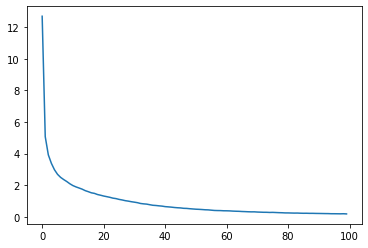

In [40]:
model_light5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_light.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_light5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_light5.load_weights("../models/LSTM_light.h5")
    logging.info("loading LSTM model from ../models/LSTM_light.h5")
except OSError as e:
    history: History = model_light5.fit(
        ds_light,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_light.h5")
    logging.info("saving LSTM model to ../models/LSTM_light.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [41]:
light_pred5 = model_light5.predict(np.expand_dims(x_test_light.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

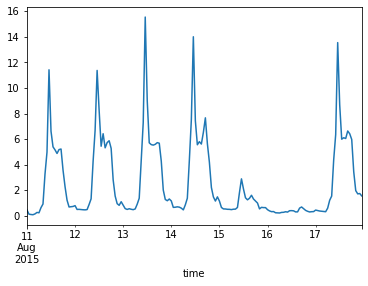

In [42]:
light_pred = (light_pred1 + light_pred2 + light_pred3 + light_pred4 + light_pred5) / 5
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"] = light_pred
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot()

<h4>针对air构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

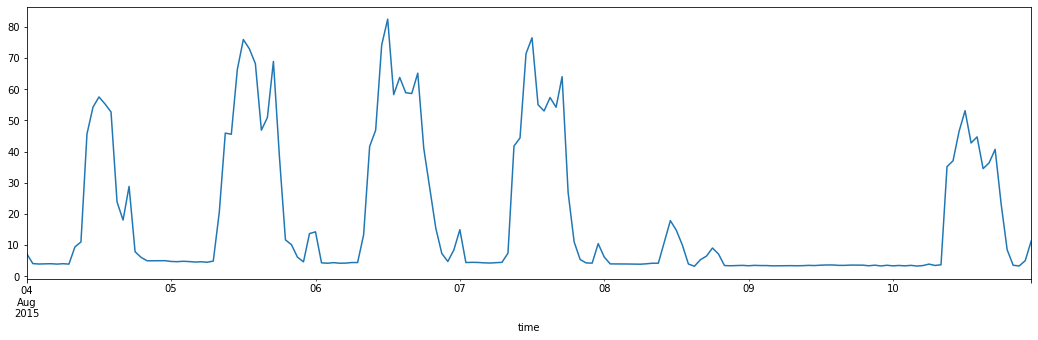

In [43]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_air"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [45]:
data_air = data.drop(columns=["value_socket", "value_light", "value_total"])
x_train_air = data_air.drop(columns=["value_air"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_air = data_air["value_air"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_air = data_air.drop(columns=["value_air"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_air.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [46]:
model_air1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred1 = model_air1.predict(x_test_air)

<h5>取最后7*24个点作为模型2预测值</h5>

In [47]:
air_pred2 = data_air.loc[: "2015-08-10 23:00:00", "value_air"].values[-7*24:]

<h5>构建catboost</h5>

In [48]:
model_air3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred3 = model_air3.predict(x_test_air)

Learning rate set to 0.063357
0:	learn: 14.1010648	total: 2.5ms	remaining: 2.5s
1:	learn: 13.5674500	total: 4.59ms	remaining: 2.29s
2:	learn: 13.0738192	total: 6.53ms	remaining: 2.17s
3:	learn: 12.6248412	total: 8.51ms	remaining: 2.12s
4:	learn: 12.2324691	total: 10.5ms	remaining: 2.08s
5:	learn: 11.8379072	total: 12.4ms	remaining: 2.05s
6:	learn: 11.4964809	total: 14.3ms	remaining: 2.02s
7:	learn: 11.1634770	total: 16.1ms	remaining: 2s
8:	learn: 10.8813787	total: 18ms	remaining: 1.98s
9:	learn: 10.6322191	total: 19.8ms	remaining: 1.96s
10:	learn: 10.3923264	total: 21.6ms	remaining: 1.94s
11:	learn: 10.1609578	total: 23.5ms	remaining: 1.93s
12:	learn: 9.9338447	total: 25.4ms	remaining: 1.93s
13:	learn: 9.7362233	total: 27.2ms	remaining: 1.92s
14:	learn: 9.5697111	total: 29.1ms	remaining: 1.91s
15:	learn: 9.4154394	total: 30.9ms	remaining: 1.9s
16:	learn: 9.2769156	total: 32.7ms	remaining: 1.89s
17:	learn: 9.1298361	total: 34.6ms	remaining: 1.89s
18:	learn: 9.0097741	total: 36.4ms	remai

193:	learn: 5.4447160	total: 357ms	remaining: 1.48s
194:	learn: 5.4335827	total: 359ms	remaining: 1.48s
195:	learn: 5.4273719	total: 361ms	remaining: 1.48s
196:	learn: 5.4243909	total: 362ms	remaining: 1.48s
197:	learn: 5.4195408	total: 364ms	remaining: 1.48s
198:	learn: 5.4118478	total: 366ms	remaining: 1.47s
199:	learn: 5.4021252	total: 368ms	remaining: 1.47s
200:	learn: 5.3948672	total: 370ms	remaining: 1.47s
201:	learn: 5.3865586	total: 372ms	remaining: 1.47s
202:	learn: 5.3816233	total: 374ms	remaining: 1.47s
203:	learn: 5.3744954	total: 376ms	remaining: 1.47s
204:	learn: 5.3682106	total: 378ms	remaining: 1.47s
205:	learn: 5.3633433	total: 380ms	remaining: 1.46s
206:	learn: 5.3523548	total: 382ms	remaining: 1.46s
207:	learn: 5.3471158	total: 384ms	remaining: 1.46s
208:	learn: 5.3402591	total: 386ms	remaining: 1.46s
209:	learn: 5.3312575	total: 387ms	remaining: 1.46s
210:	learn: 5.3252228	total: 389ms	remaining: 1.46s
211:	learn: 5.3201177	total: 391ms	remaining: 1.45s
212:	learn: 

387:	learn: 4.4998938	total: 717ms	remaining: 1.13s
388:	learn: 4.4971642	total: 719ms	remaining: 1.13s
389:	learn: 4.4931250	total: 720ms	remaining: 1.13s
390:	learn: 4.4907346	total: 722ms	remaining: 1.12s
391:	learn: 4.4890437	total: 724ms	remaining: 1.12s
392:	learn: 4.4868061	total: 726ms	remaining: 1.12s
393:	learn: 4.4836909	total: 727ms	remaining: 1.12s
394:	learn: 4.4816246	total: 729ms	remaining: 1.12s
395:	learn: 4.4786067	total: 731ms	remaining: 1.11s
396:	learn: 4.4767882	total: 733ms	remaining: 1.11s
397:	learn: 4.4730853	total: 735ms	remaining: 1.11s
398:	learn: 4.4708961	total: 737ms	remaining: 1.11s
399:	learn: 4.4676579	total: 739ms	remaining: 1.11s
400:	learn: 4.4647072	total: 741ms	remaining: 1.11s
401:	learn: 4.4615390	total: 742ms	remaining: 1.1s
402:	learn: 4.4590445	total: 744ms	remaining: 1.1s
403:	learn: 4.4554978	total: 746ms	remaining: 1.1s
404:	learn: 4.4512524	total: 748ms	remaining: 1.1s
405:	learn: 4.4482292	total: 750ms	remaining: 1.1s
406:	learn: 4.445

574:	learn: 3.9975222	total: 1.08s	remaining: 797ms
575:	learn: 3.9962627	total: 1.08s	remaining: 795ms
576:	learn: 3.9940094	total: 1.08s	remaining: 793ms
577:	learn: 3.9930163	total: 1.08s	remaining: 791ms
578:	learn: 3.9906777	total: 1.09s	remaining: 790ms
579:	learn: 3.9893001	total: 1.09s	remaining: 789ms
580:	learn: 3.9878913	total: 1.09s	remaining: 788ms
581:	learn: 3.9856451	total: 1.09s	remaining: 786ms
582:	learn: 3.9833335	total: 1.1s	remaining: 784ms
583:	learn: 3.9819036	total: 1.1s	remaining: 782ms
584:	learn: 3.9797600	total: 1.1s	remaining: 781ms
585:	learn: 3.9782968	total: 1.1s	remaining: 779ms
586:	learn: 3.9760759	total: 1.1s	remaining: 777ms
587:	learn: 3.9747713	total: 1.1s	remaining: 775ms
588:	learn: 3.9726745	total: 1.11s	remaining: 773ms
589:	learn: 3.9704844	total: 1.11s	remaining: 771ms
590:	learn: 3.9674537	total: 1.11s	remaining: 769ms
591:	learn: 3.9665275	total: 1.11s	remaining: 767ms
592:	learn: 3.9634673	total: 1.11s	remaining: 765ms
593:	learn: 3.9614

767:	learn: 3.6269221	total: 1.44s	remaining: 435ms
768:	learn: 3.6256553	total: 1.44s	remaining: 433ms
769:	learn: 3.6244325	total: 1.44s	remaining: 431ms
770:	learn: 3.6209267	total: 1.45s	remaining: 429ms
771:	learn: 3.6197813	total: 1.45s	remaining: 427ms
772:	learn: 3.6191861	total: 1.45s	remaining: 425ms
773:	learn: 3.6184175	total: 1.45s	remaining: 424ms
774:	learn: 3.6176727	total: 1.45s	remaining: 422ms
775:	learn: 3.6171251	total: 1.45s	remaining: 420ms
776:	learn: 3.6160091	total: 1.46s	remaining: 418ms
777:	learn: 3.6153122	total: 1.46s	remaining: 416ms
778:	learn: 3.6140288	total: 1.46s	remaining: 414ms
779:	learn: 3.6121248	total: 1.46s	remaining: 412ms
780:	learn: 3.6111497	total: 1.46s	remaining: 410ms
781:	learn: 3.6091180	total: 1.47s	remaining: 409ms
782:	learn: 3.6074133	total: 1.47s	remaining: 407ms
783:	learn: 3.6066322	total: 1.47s	remaining: 405ms
784:	learn: 3.6046008	total: 1.47s	remaining: 403ms
785:	learn: 3.6036319	total: 1.47s	remaining: 401ms
786:	learn: 

960:	learn: 3.3700362	total: 1.8s	remaining: 73ms
961:	learn: 3.3680795	total: 1.8s	remaining: 71.2ms
962:	learn: 3.3661880	total: 1.8s	remaining: 69.3ms
963:	learn: 3.3649989	total: 1.81s	remaining: 67.5ms
964:	learn: 3.3636294	total: 1.81s	remaining: 65.6ms
965:	learn: 3.3629049	total: 1.81s	remaining: 63.7ms
966:	learn: 3.3621734	total: 1.81s	remaining: 61.8ms
967:	learn: 3.3610835	total: 1.81s	remaining: 60ms
968:	learn: 3.3585582	total: 1.81s	remaining: 58.1ms
969:	learn: 3.3576032	total: 1.82s	remaining: 56.2ms
970:	learn: 3.3559970	total: 1.82s	remaining: 54.4ms
971:	learn: 3.3543056	total: 1.82s	remaining: 52.5ms
972:	learn: 3.3527216	total: 1.82s	remaining: 50.6ms
973:	learn: 3.3515564	total: 1.83s	remaining: 48.7ms
974:	learn: 3.3499444	total: 1.83s	remaining: 46.9ms
975:	learn: 3.3492362	total: 1.83s	remaining: 45ms
976:	learn: 3.3492014	total: 1.83s	remaining: 43.1ms
977:	learn: 3.3486073	total: 1.83s	remaining: 41.3ms
978:	learn: 3.3469008	total: 1.84s	remaining: 39.4ms
97

<h5>构建xgboost</h5>

In [51]:
model_air4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_air.loc[y_train_air > 0], y_train_air[y_train_air > 0])
air_pred4 = model_air4.predict(x_test_air)

<h5>构建深度模型</h5>

In [52]:
ds_air1 = timeseries_dataset_from_array(
    data=data_air.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air2 = timeseries_dataset_from_array(
    data=data_air.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air3 = timeseries_dataset_from_array(
    data=data_air.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air = ds_air1.concatenate(ds_air2).concatenate(ds_air3).map(split_xy)
ds_air

<MapDataset shapes: ((None, None, 27), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
124/124 [==============================] - 8s 44ms/step - loss: 444.7956 - mae: 13.2644
Epoch 2/100
124/124 [==============================] - 5s 38ms/step - loss: 307.9417 - mae: 11.8961
Epoch 3/100
124/124 [==============================] - 5s 39ms/step - loss: 189.1827 - mae: 8.9419
Epoch 4/100
124/124 [==============================] - 5s 38ms/step - loss: 118.7963 - mae: 6.9043
Epoch 5/100
124/124 [==============================] - 5s 38ms/step - loss: 97.5105 - mae: 6.2556
Epoch 6/100
124/124 [==============================] - 5s 38ms/step - loss: 81.0654 - mae: 5.6836
Epoch 7/100
124/124 [==============================] - 5s 38ms/step - loss: 72.2261 - mae: 5.3549
Epoch 8/100
124/124 [==============================] - 5s 38ms/step - loss: 60.9147 - mae: 4.9184
Epoch 9/100
124/124 [==============================] - 5s 38ms/step - loss: 54.0317 - mae: 4.6234
Epoch 10/100
124/124 [==============================] - 5s 38ms/step - loss: 50.4751 - mae: 4.4479
Epoch 11/100


124/124 [==============================] - 5s 40ms/step - loss: 5.2301 - mae: 1.3463
Epoch 85/100
124/124 [==============================] - 5s 39ms/step - loss: 4.4404 - mae: 1.2449
Epoch 86/100
124/124 [==============================] - 5s 39ms/step - loss: 4.3768 - mae: 1.2399
Epoch 87/100
124/124 [==============================] - 5s 39ms/step - loss: 4.4557 - mae: 1.2439
Epoch 88/100
124/124 [==============================] - 5s 39ms/step - loss: 4.3153 - mae: 1.2243
Epoch 89/100
124/124 [==============================] - 5s 39ms/step - loss: 4.6475 - mae: 1.2746
Epoch 90/100
124/124 [==============================] - 5s 39ms/step - loss: 4.6255 - mae: 1.2530
Epoch 91/100
124/124 [==============================] - 5s 39ms/step - loss: 4.2750 - mae: 1.2098
Epoch 92/100
124/124 [==============================] - 5s 40ms/step - loss: 4.0938 - mae: 1.1797
Epoch 93/100
124/124 [==============================] - 5s 39ms/step - loss: 4.1084 - mae: 1.1874
Epoch 94/100
124/124 [===========

2023-04-12 08:12:53,275 [INFO] saving LSTM model to ../models/LSTM_air.h5


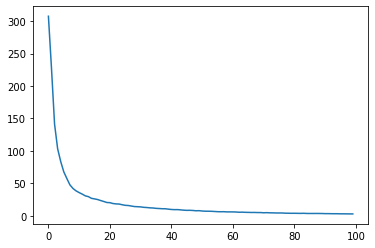

In [53]:
model_air5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_air.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_air5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_air5.load_weights("../models/LSTM_air.h5")
    logging.info("loading LSTM model from ../models/LSTM_air.h5")
except OSError as e:
    history: History = model_air5.fit(
        ds_air,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_air.h5")
    logging.info("saving LSTM model to ../models/LSTM_air.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [54]:
air_pred5 = model_air5.predict(np.expand_dims(x_test_air.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

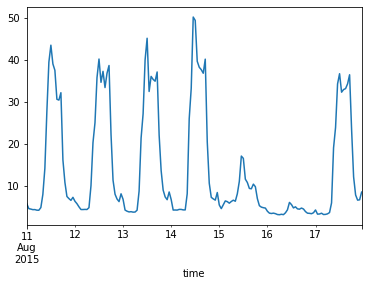

In [55]:
air_pred = (air_pred1 + air_pred2 + air_pred3 + air_pred4 + air_pred5) / 5
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"] = air_pred
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot()

<h4>针对total构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

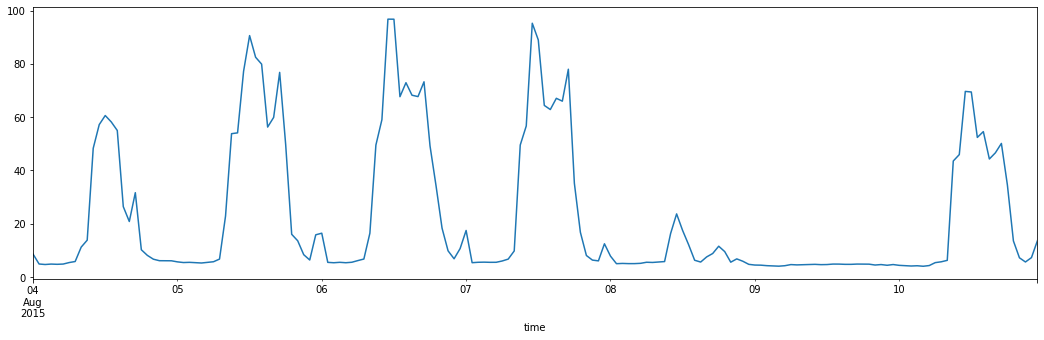

In [56]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_total"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [67]:
data_total = data.drop(columns=["value_socket", "value_light", "value_air"])
x_train_total = data_total.drop(columns=["value_total"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = data_total["value_total"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = y_train_total[y_train_total > 0]
x_train_total = x_train_total.loc[y_train_total.index]
x_test_total = data_total.drop(columns=["value_total"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_total.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [68]:
model_total1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred1 = model_total1.predict(x_test_total)

<h5>取最后7*24个点作为模型2预测值</h5>

In [69]:
total_pred2 = data_total.loc[: "2015-08-10 23:00:00", "value_total"].values[-7*24:]

<h5>构建catboost</h5>

In [70]:
model_total3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred3 = model_total3.predict(x_test_total)

Learning rate set to 0.063357
0:	learn: 17.9276375	total: 2.6ms	remaining: 2.6s
1:	learn: 17.1626631	total: 4.95ms	remaining: 2.47s
2:	learn: 16.4640932	total: 7.24ms	remaining: 2.41s
3:	learn: 15.8245340	total: 9.27ms	remaining: 2.31s
4:	learn: 15.2310857	total: 11.3ms	remaining: 2.24s
5:	learn: 14.6917422	total: 13.2ms	remaining: 2.18s
6:	learn: 14.1952735	total: 15ms	remaining: 2.13s
7:	learn: 13.7321134	total: 16.9ms	remaining: 2.09s
8:	learn: 13.3198822	total: 18.7ms	remaining: 2.06s
9:	learn: 12.9344668	total: 20.6ms	remaining: 2.04s
10:	learn: 12.5740707	total: 22.4ms	remaining: 2.02s
11:	learn: 12.2582442	total: 24.3ms	remaining: 2s
12:	learn: 11.9654910	total: 26.1ms	remaining: 1.98s
13:	learn: 11.6884422	total: 28ms	remaining: 1.97s
14:	learn: 11.4365195	total: 29.8ms	remaining: 1.96s
15:	learn: 11.2260748	total: 31.7ms	remaining: 1.95s
16:	learn: 11.0070804	total: 33.6ms	remaining: 1.94s
17:	learn: 10.8211920	total: 35.4ms	remaining: 1.93s
18:	learn: 10.6421327	total: 37.3ms

179:	learn: 6.2798869	total: 352ms	remaining: 1.6s
180:	learn: 6.2637863	total: 354ms	remaining: 1.6s
181:	learn: 6.2562191	total: 356ms	remaining: 1.6s
182:	learn: 6.2454951	total: 357ms	remaining: 1.59s
183:	learn: 6.2341346	total: 359ms	remaining: 1.59s
184:	learn: 6.2245969	total: 361ms	remaining: 1.59s
185:	learn: 6.2178054	total: 363ms	remaining: 1.59s
186:	learn: 6.2080918	total: 365ms	remaining: 1.59s
187:	learn: 6.2003449	total: 367ms	remaining: 1.58s
188:	learn: 6.1942965	total: 369ms	remaining: 1.58s
189:	learn: 6.1905011	total: 371ms	remaining: 1.58s
190:	learn: 6.1761884	total: 373ms	remaining: 1.58s
191:	learn: 6.1699766	total: 375ms	remaining: 1.58s
192:	learn: 6.1624982	total: 377ms	remaining: 1.57s
193:	learn: 6.1581038	total: 379ms	remaining: 1.57s
194:	learn: 6.1470958	total: 381ms	remaining: 1.57s
195:	learn: 6.1385381	total: 382ms	remaining: 1.57s
196:	learn: 6.1324580	total: 384ms	remaining: 1.57s
197:	learn: 6.1278221	total: 386ms	remaining: 1.56s
198:	learn: 6.1

372:	learn: 5.1708228	total: 714ms	remaining: 1.2s
373:	learn: 5.1651030	total: 716ms	remaining: 1.2s
374:	learn: 5.1626816	total: 718ms	remaining: 1.2s
375:	learn: 5.1586778	total: 720ms	remaining: 1.19s
376:	learn: 5.1546175	total: 722ms	remaining: 1.19s
377:	learn: 5.1529198	total: 723ms	remaining: 1.19s
378:	learn: 5.1501999	total: 725ms	remaining: 1.19s
379:	learn: 5.1476374	total: 727ms	remaining: 1.19s
380:	learn: 5.1455802	total: 729ms	remaining: 1.18s
381:	learn: 5.1434898	total: 731ms	remaining: 1.18s
382:	learn: 5.1405055	total: 733ms	remaining: 1.18s
383:	learn: 5.1369032	total: 735ms	remaining: 1.18s
384:	learn: 5.1307829	total: 736ms	remaining: 1.18s
385:	learn: 5.1255063	total: 738ms	remaining: 1.17s
386:	learn: 5.1230816	total: 740ms	remaining: 1.17s
387:	learn: 5.1195449	total: 742ms	remaining: 1.17s
388:	learn: 5.1156145	total: 744ms	remaining: 1.17s
389:	learn: 5.1122442	total: 746ms	remaining: 1.17s
390:	learn: 5.1073647	total: 748ms	remaining: 1.16s
391:	learn: 5.1

564:	learn: 4.5398468	total: 1.07s	remaining: 828ms
565:	learn: 4.5385146	total: 1.08s	remaining: 826ms
566:	learn: 4.5366795	total: 1.08s	remaining: 824ms
567:	learn: 4.5336117	total: 1.08s	remaining: 822ms
568:	learn: 4.5324333	total: 1.08s	remaining: 821ms
569:	learn: 4.5283424	total: 1.09s	remaining: 822ms
570:	learn: 4.5249137	total: 1.09s	remaining: 820ms
571:	learn: 4.5235455	total: 1.09s	remaining: 818ms
572:	learn: 4.5215548	total: 1.09s	remaining: 816ms
573:	learn: 4.5179901	total: 1.1s	remaining: 815ms
574:	learn: 4.5153818	total: 1.1s	remaining: 813ms
575:	learn: 4.5136263	total: 1.1s	remaining: 811ms
576:	learn: 4.5118055	total: 1.1s	remaining: 809ms
577:	learn: 4.5097231	total: 1.1s	remaining: 807ms
578:	learn: 4.5073401	total: 1.11s	remaining: 805ms
579:	learn: 4.5057147	total: 1.11s	remaining: 803ms
580:	learn: 4.5044920	total: 1.11s	remaining: 801ms
581:	learn: 4.5019044	total: 1.11s	remaining: 799ms
582:	learn: 4.5003017	total: 1.11s	remaining: 798ms
583:	learn: 4.496

751:	learn: 4.1322379	total: 1.44s	remaining: 474ms
752:	learn: 4.1301452	total: 1.44s	remaining: 472ms
753:	learn: 4.1276339	total: 1.44s	remaining: 470ms
754:	learn: 4.1255197	total: 1.45s	remaining: 470ms
755:	learn: 4.1234329	total: 1.45s	remaining: 468ms
756:	learn: 4.1212143	total: 1.45s	remaining: 466ms
757:	learn: 4.1187787	total: 1.45s	remaining: 464ms
758:	learn: 4.1164281	total: 1.46s	remaining: 462ms
759:	learn: 4.1151152	total: 1.46s	remaining: 460ms
760:	learn: 4.1132266	total: 1.46s	remaining: 459ms
761:	learn: 4.1121115	total: 1.46s	remaining: 457ms
762:	learn: 4.1102741	total: 1.46s	remaining: 455ms
763:	learn: 4.1081667	total: 1.47s	remaining: 453ms
764:	learn: 4.1070339	total: 1.47s	remaining: 451ms
765:	learn: 4.1045230	total: 1.47s	remaining: 449ms
766:	learn: 4.1030808	total: 1.47s	remaining: 447ms
767:	learn: 4.1015526	total: 1.47s	remaining: 445ms
768:	learn: 4.1002052	total: 1.48s	remaining: 443ms
769:	learn: 4.0985197	total: 1.48s	remaining: 441ms
770:	learn: 

938:	learn: 3.8448979	total: 1.8s	remaining: 117ms
939:	learn: 3.8434943	total: 1.8s	remaining: 115ms
940:	learn: 3.8415694	total: 1.8s	remaining: 113ms
941:	learn: 3.8394708	total: 1.8s	remaining: 111ms
942:	learn: 3.8383462	total: 1.8s	remaining: 109ms
943:	learn: 3.8367773	total: 1.81s	remaining: 107ms
944:	learn: 3.8359357	total: 1.81s	remaining: 105ms
945:	learn: 3.8337844	total: 1.81s	remaining: 103ms
946:	learn: 3.8324261	total: 1.81s	remaining: 101ms
947:	learn: 3.8312163	total: 1.81s	remaining: 99.5ms
948:	learn: 3.8293149	total: 1.81s	remaining: 97.6ms
949:	learn: 3.8284753	total: 1.82s	remaining: 95.7ms
950:	learn: 3.8265758	total: 1.82s	remaining: 93.7ms
951:	learn: 3.8258013	total: 1.82s	remaining: 91.8ms
952:	learn: 3.8246642	total: 1.82s	remaining: 89.9ms
953:	learn: 3.8242260	total: 1.82s	remaining: 88ms
954:	learn: 3.8223389	total: 1.83s	remaining: 86.1ms
955:	learn: 3.8210407	total: 1.83s	remaining: 84.2ms
956:	learn: 3.8202913	total: 1.83s	remaining: 82.3ms
957:	lear

<h5>构建xgboost</h5>

In [71]:
model_total4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_total, y_train_total)
total_pred4 = model_total4.predict(x_test_total)
# TODO 改为objective='reg:linear'，并加入sample_weight

<h5>构建深度模型</h5>

In [72]:
ds_total1 = timeseries_dataset_from_array(
    data=data_total.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total2 = timeseries_dataset_from_array(
    data=data_total.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total3 = timeseries_dataset_from_array(
    data=data_total.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total = ds_total1.concatenate(ds_total2).concatenate(ds_total3).map(split_xy)
ds_total

<MapDataset shapes: ((None, None, 27), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
124/124 [==============================] - 7s 44ms/step - loss: 752.3808 - mae: 18.3547
Epoch 2/100
124/124 [==============================] - 5s 38ms/step - loss: 288.0714 - mae: 10.6696
Epoch 3/100
124/124 [==============================] - 5s 38ms/step - loss: 192.2228 - mae: 8.7814
Epoch 4/100
124/124 [==============================] - 5s 38ms/step - loss: 129.5188 - mae: 7.2284
Epoch 5/100
124/124 [==============================] - 5s 38ms/step - loss: 100.5065 - mae: 6.3797
Epoch 6/100
124/124 [==============================] - 5s 37ms/step - loss: 80.6569 - mae: 5.7449
Epoch 7/100
124/124 [==============================] - 5s 38ms/step - loss: 68.1910 - mae: 5.3247
Epoch 8/100
124/124 [==============================] - 5s 38ms/step - loss: 60.6469 - mae: 5.0291
Epoch 9/100
124/124 [==============================] - 5s 38ms/step - loss: 54.7622 - mae: 4.7851
Epoch 10/100
124/124 [==============================] - 5s 38ms/step - loss: 49.9449 - mae: 4.5845
Epoch 11/100

124/124 [==============================] - 5s 39ms/step - loss: 6.5809 - mae: 1.5243
Epoch 85/100
124/124 [==============================] - 5s 40ms/step - loss: 5.7132 - mae: 1.4267
Epoch 86/100
124/124 [==============================] - 5s 39ms/step - loss: 5.5376 - mae: 1.4037
Epoch 87/100
124/124 [==============================] - 5s 39ms/step - loss: 5.5895 - mae: 1.4148
Epoch 88/100
124/124 [==============================] - 5s 40ms/step - loss: 5.5815 - mae: 1.4008
Epoch 89/100
124/124 [==============================] - 5s 40ms/step - loss: 5.5400 - mae: 1.3875
Epoch 90/100
124/124 [==============================] - 5s 39ms/step - loss: 5.5991 - mae: 1.3943
Epoch 91/100
124/124 [==============================] - 5s 39ms/step - loss: 5.3357 - mae: 1.3701
Epoch 92/100
124/124 [==============================] - 5s 40ms/step - loss: 5.0938 - mae: 1.3315
Epoch 93/100
124/124 [==============================] - 5s 39ms/step - loss: 5.4338 - mae: 1.3846
Epoch 94/100
124/124 [===========

2023-04-12 08:30:27,024 [INFO] saving LSTM model to ../models/LSTM_total.h5


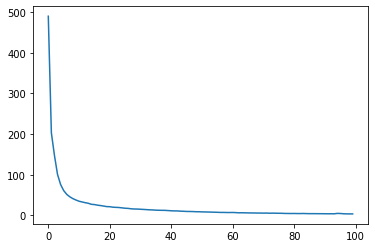

In [73]:
model_total5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_total.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_total5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_total5.load_weights("../models/LSTM_total.h5")
    logging.info("loading LSTM model from ../models/LSTM_total.h5")
except OSError as e:
    history: History = model_total5.fit(
        ds_total,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_total5.save_weights("../models/LSTM_total.h5")
    logging.info("saving LSTM model to ../models/LSTM_total.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [74]:
total_pred5 = model_total5.predict(np.expand_dims(x_test_total.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

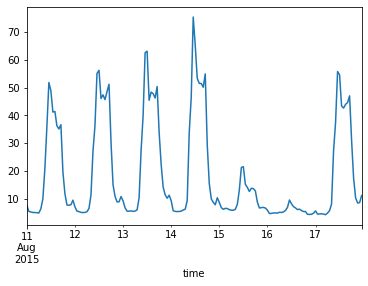

In [75]:
total_pred = (total_pred1 + total_pred2 + total_pred3 + total_pred4 + total_pred5) / 5
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"] = total_pred
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot()

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [76]:
results = DataFrame(index=pd.date_range(start="2015-08-11 00:00:00", end="2015-08-17 23:00:00", freq="1H"))
results['socket'] = clip_value(socket_pred, _min_val_=0)
results['light'] = clip_value(light_pred, _min_val_=0)
results['air'] = clip_value(air_pred, _min_val_=0)
results['total'] = clip_value(total_pred, _min_val_=0)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

,total,socket,light,air
2015-08-11 00:00:00,7.557214,0.830647,0.469856,5.677590
2015-08-11 01:00:00,5.351056,0.612892,0.127929,4.534254
2015-08-11 02:00:00,5.151216,0.598679,0.102361,4.430052
2015-08-11 03:00:00,4.976837,0.608496,0.085933,4.293211
2015-08-11 04:00:00,4.963610,0.632646,0.148838,4.310853
...,...,...,...,...
2015-08-17 19:00:00,17.344363,1.409483,3.452355,12.113427
2015-08-17 20:00:00,10.258015,1.227533,1.972369,7.795356
2015-08-17 21:00:00,8.406789,1.129552,1.717407,6.561386
2015-08-17 22:00:00,8.525841,1.074885,1.744602,6.646609


In [77]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)